# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [83]:
# Add your imports here

import pandas as pd
import numpy as np
import scipy as sp
from pyspark.sql import *
%matplotlib inline
from collections import Counter
import re
from pathlib import Path
import matplotlib.pyplot as plt



In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
DATA_DIR = 'data/'
POST_PATH = DATA_DIR + "Posts.json"
POST_PQ = "Posts.parquet"
TAGS_PQ = "Tags.parquet"
QUESTIONS_PQ = "Questions.parquet"
ANSWERS_PQ = "Answers.parquet"

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [4]:
# Load dataset into Spark Dataframe
posts_df = spark.read.json(POST_PATH)
# Save data set into Parquet
if not Path(POST_PQ).exists():
    print("Saving {} ...".format(POST_PATH))
    posts_df.write.save(POST_PQ)
posts_df.show()

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26T03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
|2010-10-26T03:20:...|4020444| 4020433|         2|    0|                null|                null|     null|
|2010-10-26T03:21:.

In [8]:
posts = spark.read.parquet(POST_PQ)

In [33]:
# 1. How many questions have been asked on StackOverflow?
questions = posts.filter(posts['PostTypeId'] == 1)
nb_questions = questions.count()
# Save for later use
if not Path(QUESTIONS_PQ).exists():
    print("Saving {} ...".format(QUESTIONS_PQ))
    questions.write.save(QUESTIONS_PQ)
print("There are {} questions asked on StackOverflow.".format(nb_questions))

There are 15647060 questions asked on StackOverflow.


In [6]:
# 2. How many answers have been given?
nb_answers = posts.filter(posts['PostTypeId'] == 2).count()
print("There are {} answers given on StackOverflow.".format(nb_answers))

There are 25192772 answers given on StackOverflow.


In [7]:
# 3. What is the percentage of questions with a score of 0?
nb_quest_0_score = questions.filter(questions['Score'] == 0).count()
percentage_0_score = float(nb_quest_0_score) / float(nb_questions) * 100
print("{} % of the questions have score of 0.".format(percentage_0_score))

46.54365740273253 % of the questions have score of 0.


**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

#### 1. What is the proportion of tags that appear in fewer than 100 questions?

1. Get the total number of distinct tags.
2. Extract the tags from the question posts
3. Filter to get the tags that appear less than 100 times (assuming that we cannot have a tag to appear twice in the same question).
4. Calculate the proportion.

In [6]:
# If first time : create the rdd
if not Path(TAGS_PQ).exists():
    # Remove all null tags
    print("Saving {}...".format(TAGS_PQ))
    tags_rows = posts.filter(posts['Tags'] != "null")
    tags = tags_rows.select(tags_rows['Tags'])
    tags.write.save(TAGS_PQ)

# Read previously saved files
questions_df = spark.read.parquet(QUESTIONS_PQ)
tags_df = spark.read.parquet(TAGS_PQ)
tags_rdd = tags_df.rdd

In [11]:
# Get number of all tags
all_tags = tags_rdd.flatMap(lambda x: re.findall(r'<(.*?)>', x[0]))
all_tags_distinct = all_tags.distinct()
nb_tags = all_tags_distinct.count()

In [12]:
question_tags_rdd = questions_df.select(questions_df['Tags']).rdd
# Get all tags from the questions
question_tags = question_tags_rdd.flatMap(lambda x: re.findall(r'<(.*?)>', x[0])) \
                                 .map(lambda x: (x, 1)) 
questions_tags_frequence = question_tags.reduceByKey(lambda x, y: x + y)

In [37]:
# Calculate the proportion of tags that appear in less than 100 questions
all_questions_tags_count = questions_tags_frequence.count()
less_than_100_questions = questions_tags_frequence.filter(lambda x: int(x[1]) < 100)
less_than_100_questions_count = less_than_100_questions.count()
less_than_100_questions_proportion = less_than_100_questions_count / nb_tags * 100
print("There are {} % of tags that appear in less than 100 questions".format(less_than_100_questions_proportion))

There are 67.97939389364834 % of tags that appear in less than 100 questions


#### 2. Plot the distribution of the tag counts using an appropriate representation.

1. Get the pandas dataframe of all the tags.
2. Plot the histogram of all tags.

In [13]:
# Get all the tags count
questions_tags_frequence_list = questions_tags_frequence.collect()

In [14]:
# Create pandas data frame
questions_tags_count = [i[1] for i in questions_tags_frequence_list]
questions_tags_frequence_df = pd.DataFrame(data=questions_tags_count, columns=['Frequence'])
questions_tags_frequence_df.sort_values(by='Frequence', ascending=False).head()

,Frequence
19032,1585495
15218,1352735
3803,1172492
22841,1136082
22836,1088811


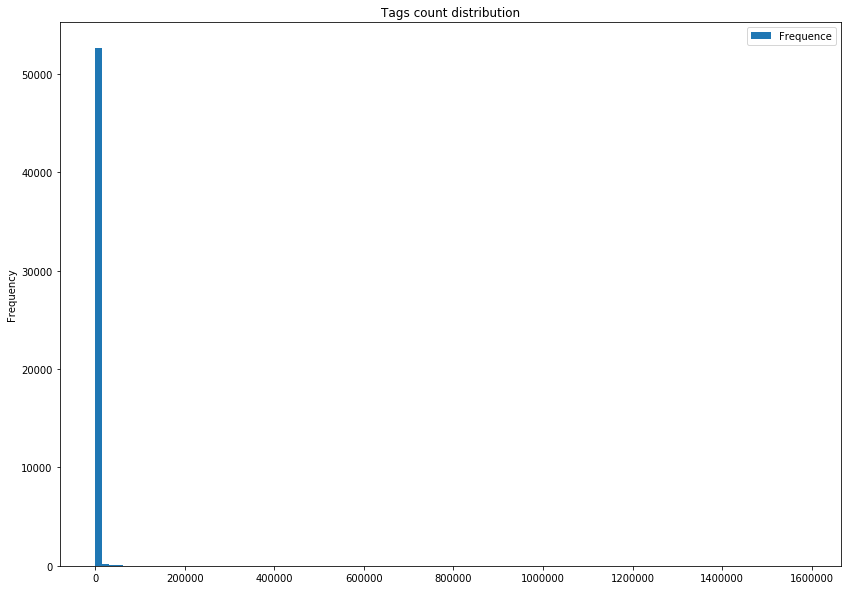

In [15]:
# Sort by frequence of each tags
questions_tags_frequence_df.plot.hist(title='Tags count distribution', figsize= (14, 10), bins=100)

We notice that most (around 68%) of the tags are used than less than 100 questions. It is therefore normal to observe that ther are a huge bar for all the tags that are use less than 100 times, and some almost inexistant bars after that for the rest of the tags that are used very frequently.

#### 3. Plot a bar chart with the number of questions for the 10 most popular tags.
1. Sort the questions_tags_frequence by the number of times present in the questions
2. Take the top ten (tags, frequence)
3. Plot the bar chart with pandas df.

In [25]:
# Take top 10 tags from the questions tags
top_10_tags = questions_tags_frequence.sortBy(lambda r: r[1], ascending = False).take(10)

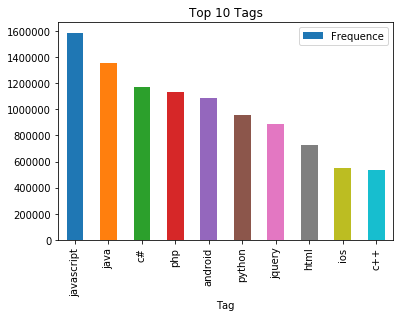

In [33]:
top_10_tags_df = pd.DataFrame(data=top_10_tags, columns=['Tag', 'Frequence'])
top_10_tags_df.plot.bar(x='Tag', y='Frequence', rot=90, title='Top 10 Tags')

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

#### 1. Get the view count and score of the questions with tag random-effects and visualize the relation between these two variables using an appropriate plot.
1. Get all the question rows with random-effets as tag.
2. Extract the view count and the scores from questions.
3. Plot a scatter plot to show the relationship.

In [79]:
# Get all the question rows with random-effect as tag
random_effets_df = questions_df.select("Tags", "Score", "ViewCount")\
                               .filter(questions_df.Tags.like('%random-effects%'))

random_effets_pd_df = random_effets_df.toPandas()

In [80]:
# Count the number of questions random_effect questions per score
random_effets_pd_df.groupby(random_effets_pd_df.Score).size()

Score
-2      1
-1      1
 0     49
 1     27
 2     10
 3      2
 4      3
 5      1
 6      2
 7      1
 8      1
 25     1
 31     1
dtype: int64

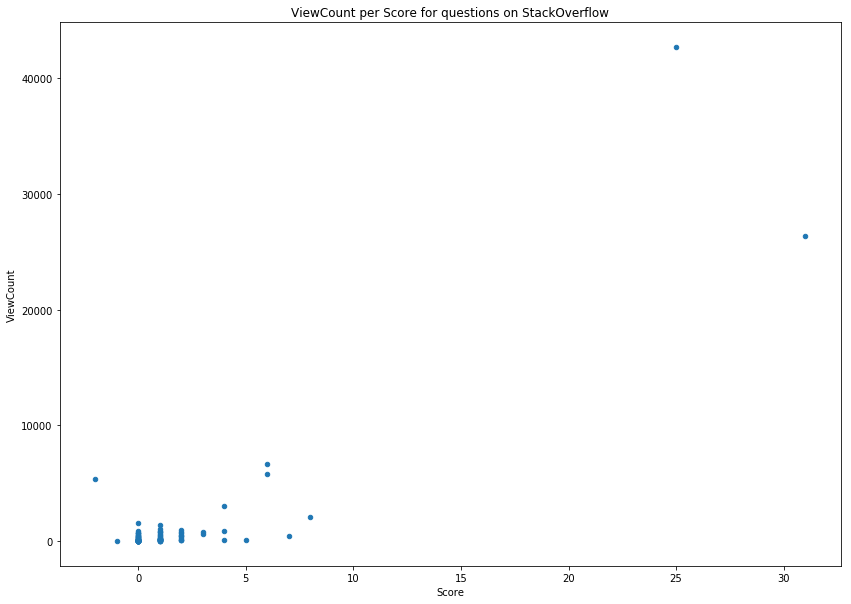

In [81]:
random_effets_pd_df.plot.scatter(x="Score", y="ViewCount", figsize=(14, 10), title="ViewCount per Score for questions on StackOverflow")

#### Follow up: 
We see that most of the questions have a score between 0, 1 and 2 from the results given by the groupby function above. All the questions having a score lower than 10 do not attain more than 10 000 views. We also notice that there are only 2 questions having a score of 25 and 31 respectively, also have a extremely high view counts. This somehow hints at a correlation existing between the 2 variables - the higher the score, the more likely people will to come consult the question; the more views the question get, the higher the change people vote to add a point on the score. 

#### 2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.
1. Calculate the Pearson coefficient.
2. Discussion (see below)

In [73]:
random_effets_pd_df.corr(method='pearson')

,Score,ViewCount
Score,1.000000,0.882197
ViewCount,0.882197,1.000000


Effectively, these 2 variables have a high Pearson linear correlation. As said in the previous questions, there exists a fairly strong correlation between these 2 variables: the higher the score, the more likely people will to come consult the question; the more views the question get, the higher the change people vote to add a point on the score. 

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


#### 1. Get the response time for the first answer of the questions with the tags python and java.
1. Filter the questions having python and java in the tags.
2. Find the corresponding answer that is answered at the earliest time.
3. Select the response time column.

In [9]:
# Filter out the answers
answers = posts.filter(posts['PostTypeId'] == 2)
if not Path(ANSWERS_PQ).exists():
    print("Saving {} ...".format(ANSWERS_PQ))
    answers.write.save(ANSWERS_PQ)

answers_id = answers.select("CreationDate", "ParentId")

In [10]:
# Filter all the questions having java as tag
questions_java = questions_df.filter(questions_df.Tags.like('%<java>%'))
questions_java_Id = questions_java.withColumnRenamed("Id", "Question_Id").withColumnRenamed("CreationDate", "CreationDate_Question").select("Question_Id", "CreationDate_Question")
questions_java_answers = answers.join(questions_java_Id, answers.ParentId == questions_java_Id.Question_Id)
# Convert to pandas dataframe for easier manipulation
first_questions_java_answers_pd = questions_java_answers.toPandas()

In [11]:
# Transform into DateTime
first_questions_java_answers_pd['CreationDate'] =  pd.to_datetime(first_questions_java_answers_pd['CreationDate'])
first_questions_java_answers_pd['CreationDate_Question'] =  pd.to_datetime(first_questions_java_answers_pd['CreationDate_Question'])
# Sort and groupby to get the first answered 
first_questions_java_time = first_questions_java_answers_pd.sort_values(by=['Question_Id', 'CreationDate']).groupby('Question_Id').head(1)

We noticed that there are anomalies: some questions' creation date is before the Response's creation date. An example is shown below. The question having questionId 15228742 should have been asked in year 2013, but it has been answered in 2010, which doesn't make sense. 

In [113]:
first_questions_java_time.loc[first_questions_java_answers_pd.Question_Id == 15228742]

,CreationDate,Id,ParentId,PostTypeId,Score,Tags,Title,ViewCount,Question_Id,CreationDate_Question
943069,2010-01-04 18:46:16.307,2001707,15228742,2,0,None,None,None,15228742,2013-03-05 15:15:03.503


In [114]:
questions_df.filter(questions_df['Id'] == 15228742).select('Id', 'CreationDate', 'Title').show(1, False)

+--------+-----------------------------+-----------------------------------+
|Id      |CreationDate                 |Title                              |
+--------+-----------------------------+-----------------------------------+
|15228742|2013-03-05T16:15:03.503+01:00|Or operand with int in if statement|
+--------+-----------------------------+-----------------------------------+



We have found the corresponding question from StackOverflow:

**Notice that the comments under the question date from 2010, while the question was asked in 2013**.
<img src="Question 15228742.png">

In [123]:
# Calculate response time
first_questions_java_time["Response_Time_Java"] = first_questions_java_time.CreationDate - first_questions_java_time.CreationDate_Question
Response_Time_Java = first_questions_java_time.CreationDate - first_questions_java_time.CreationDate_Question
first_questions_java_time.sort_values(by='Response_Time_Java').head()

,CreationDate,Id,ParentId,PostTypeId,Score,Tags,Title,ViewCount,Question_Id,CreationDate_Question,Response_Time_Java
943069,2010-01-04 18:46:16.307,2001707,15228742,2,0,None,None,None,15228742,2013-03-05 15:15:03.503,-1156 days +03:31:12.804000
1437873,2008-09-18 18:39:32.130,96693,7101992,2,3,None,None,None,7101992,2011-08-18 01:19:01.337,-1064 days +17:20:30.793000
205236,2009-08-31 00:34:58.873,1355579,7456462,2,2,None,None,None,7456462,2011-09-17 15:10:04.460,-748 days +09:24:54.413000
814479,2008-11-09 08:57:29.877,275787,2206378,2,-2,None,None,None,2206378,2010-02-05 09:00:57.553,-454 days +23:56:32.324000
568732,2011-08-14 10:24:48.410,7056782,13102045,2,168,None,None,None,13102045,2012-10-27 14:37:01.840,-441 days +19:47:46.570000


As we see above, because of Question's creation date > Answer Creation Date, we get negative response time (which doesn't make sense. Therefore we decided to drop these rows.

In [125]:
# Filter out negative Response Time
Response_Time_Java = Response_Time_Java[Response_Time_Java > pd.Timedelta(0)]

print("Here are some examples of the response time for questions having Java as tag:")
Response_Time_Java.head(5)

Here are some examples of the response time for questions having Java as tag:


1074681   00:22:51.077000
1221662   00:00:20.890000
89803     00:08:10.657000
1334378   01:35:42.067000
135102    00:15:26.474000
dtype: timedelta64[ns]

Now we do the same process for questions with tag `<python>`.

In [22]:
# Filter all the questions having python as tag
questions_python = questions_df.filter(questions_df.Tags.like('%<python>%'))
questions_python_Id = questions_python.withColumnRenamed("Id", "Question_Id").withColumnRenamed("CreationDate", "CreationDate_Question").select("Question_Id", "CreationDate_Question")
questions_python_answers = answers.join(questions_python_Id, answers.ParentId == questions_python_Id.Question_Id)
# Convert to pandas dataframe for easier manipulation
first_questions_python_answers_pd = questions_python_answers.toPandas()

In [23]:
# Transform into date time
first_questions_python_answers_pd['CreationDate'] =  pd.to_datetime(first_questions_python_answers_pd['CreationDate'])
first_questions_python_answers_pd['CreationDate_Question'] =  pd.to_datetime(first_questions_python_answers_pd['CreationDate_Question'])

# Sort by Date first, then take the first answer per each group of questions
first_questions_python_time = first_questions_python_answers_pd.sort_values(by= ['Question_Id', 'CreationDate']).groupby('Question_Id').head(1)

In [24]:
# Calculate response time
Response_Time_Python = first_questions_python_time.CreationDate - first_questions_python_time.CreationDate_Question
# Filter out negative response time
Response_Time_Python = Response_Time_Python[Response_Time_Python > pd.Timedelta(0)]

print("Here are the response time for questions having Python as tag: ")
Response_Time_Python.head(5)

Here are the response time for questions having Python as tag: 


1456106   01:45:37.463000
44141     01:47:09.240000
745855    00:13:01.673000
1134721   00:02:27.886000
694648    01:11:33.867000
dtype: timedelta64[ns]

#### 2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

We see that the majority of the questions received their first reply very quickly. This show that StackOverflow has an active community. In fact, the statictics (mean, median, std) for Java and Python questions are quite similar. The std for Java is slightly larger than the Python one, but their means are very close.

In [129]:
# JAVA - Find mean, median,std
print("mean: {}\nmedian: {}\nstd: {}".format(Response_Time_Java.mean(), Response_Time_Java.median(), Response_Time_Java.std()))

mean: 11 days 13:27:45.370319
median: 0 days 00:20:24.132000
std: 82 days 13:23:48.127366


In [130]:
# PYTHON - Find mean, median,std
print("mean: {}\nmedian: {}\nstd: {}".format(Response_Time_Python.mean(), Response_Time_Python.median(), Response_Time_Python.std()))


mean: 11 days 09:15:05.288521
median: 0 days 00:22:36.932000
std: 79 days 22:59:45.400525


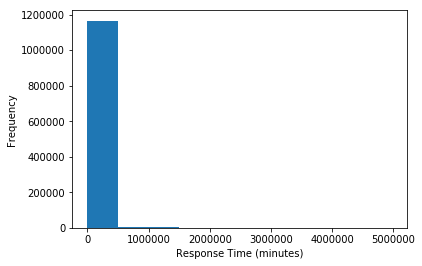

In [131]:
# JAVA - Convert to minutes and plot
Response_Time_Java_min =  Response_Time_Java / pd.Timedelta(minutes=1)
ax_java = Response_Time_Java_min.plot.hist()
ax_java = ax_java.set_xlabel("Response Time (minutes)")

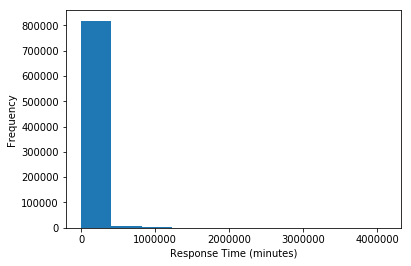

In [132]:
# PYTHON - Convert to minutes and plot
Response_Time_Python_min = Response_Time_Python / pd.Timedelta(minutes=1)
ax_py = Response_Time_Python_min.plot.hist()
ax_py = ax_py.set_xlabel("Response Time (minutes)")

#### 3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

We choose 100 groups of samples, each containing 100 samples.

We are using Means and Medians, because median is more robust than mean.

In [192]:
def bootstraping(data, nb_grs = 1000):
    """Function perform bootstrapping
       Samples 1000 groups with 1000 samples per group
       Returns Means and Medians of each sample 
    """
    medians = []
    means = []
    stds = []
    
    nb_samples = len(data)
    for i in range(nb_grs):
        sample = data.sample(nb_samples, replace=True)
        means.append(sample.mean())
        medians.append(sample.median())
        stds.append(sample.std())
    
    return pd.DataFrame(data = means, columns=['Mean']), pd.DataFrame(data = medians, columns=['Median']), stds

java_means, java_medians, java_stds = bootstraping(Response_Time_Java_min)
python_means, python_medians, python_stds = bootstraping(Response_Time_Python_min)


We can see from the following plots that the difference between the means is larger; the difference between the std for Java and Python response timesare not that large (about 6 min).

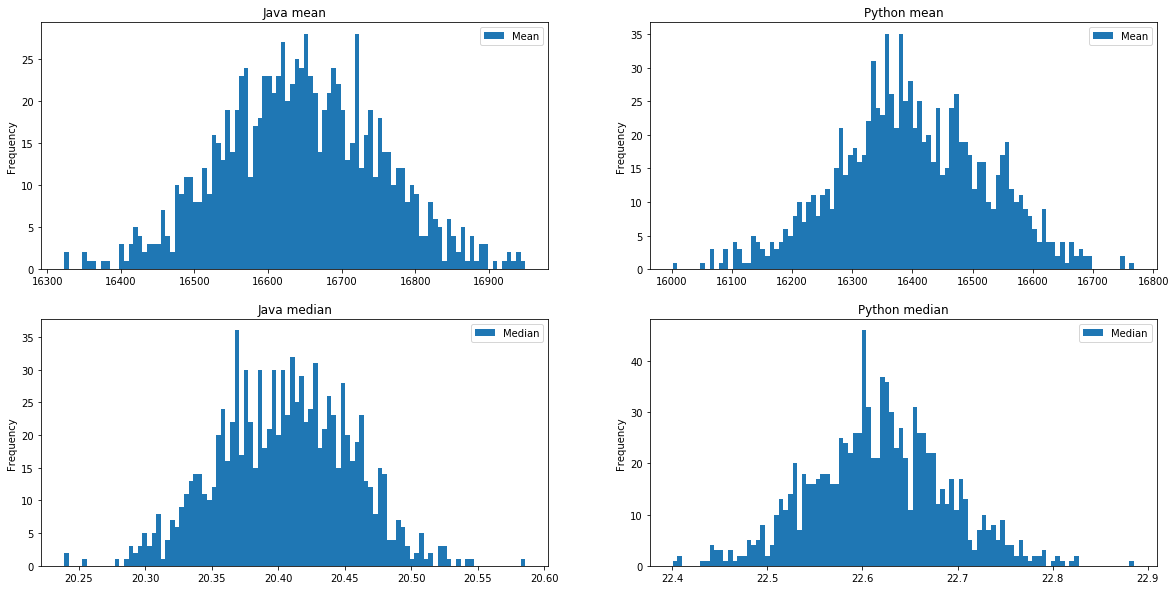

In [193]:
fig = plt.figure(figsize=(20,10))

# Divide into 4 sections
ax11 = fig.add_subplot(221)
ax12 = fig.add_subplot(222)
ax21 = fig.add_subplot(223)
ax22 = fig.add_subplot(224)

java_means.plot.hist(bins=100, title="Java mean", ax=ax11)
java_medians.plot.hist(bins=100, title="Java median", ax=ax21)

python_means.plot.hist(bins=100, title="Python mean", ax=ax12)
python_medians.plot.hist(bins=100, title="Python median", ax=ax22)

In [208]:
def compute_test_stat(java, python, java_std, python_std):
    ts = []
    n1 = len(Response_Time_Java_min)
    n2 = len(Response_Time_Python_min)
    for j, p, js, ps in zip(java, python, java_std, python_std):
        # compute std
        std_p = np.sqrt(((n1-1)* (float(js)**2) + (n2-1) * (float(ps)**2))/(n1 + n2 - 2))
        # compute test statistics
        t = (j - p) / (std_p * np.sqrt(1/n1 + 1/n2))
        ts.append(t)
    return ts

obs_mean = compute_test_stat([Response_Time_Java_min.mean()], [Response_Time_Python_min.mean()], [Response_Time_Java_min.std()], [Response_Time_Python_min.std()])
obs_median = compute_test_stat([Response_Time_Java_min.median()], [Response_Time_Python_min.median()], [Response_Time_Java_min.std()], [Response_Time_Python_min.std()])
print("The observed test statistics are: \nt-mean:{}; t-median:{}".format(obs_mean, obs_median))

The observed test statistics are: 
t-mean:[1.5009654135436237]; t-median:[-0.013148227666329641]


In [ ]:
# Let's continue our calculation for test statistics
# Calculate the difference
means_diff = java_means - python_means
median_diff = java_medians - python_medians

# Check if the java_means are actually larger than the python means / medians 
# - i.e. the diff between means/medians java - python > 0
p_mean = len(means_diff[means_diff.Mean > 0]) / len(means_diff)
p_median = len(median_diff[median_diff.Median > 0]) / len(median_diff)

print("For difference in mean, there are {}% of the samples where there is a difference for ")

In [212]:
# Test-values
ts_mean = compute_test_stat(java_means.Mean.tolist(), python_means.Mean.tolist(), java_stds, python_stds)
ts_median = compute_test_stat(java_medians.Median.tolist(), python_medians.Median.tolist(), java_stds, python_stds)

ts_mean_df = pd.DataFrame(data=ts_mean, columns=["Mean"])
ts_median_df = pd.DataFrame(data=ts_median, columns=["Median"])

p_ts_mean = len(ts_mean_df[ts_mean_df.Mean > 1.96]) / len(ts_mean_df)
p_ts_median = len(ts_mean_df[ts_median_df.Median > 1.96]) / len(ts_median_df)

p_mean, p_median, p_ts_mean, p_ts_median



(0.926, 0.0, 0.305, 0.0)

In [213]:
a = Response_Time_Python_min.to_frame()
force_a = a.as_matrix(columns=a.columns[0:1]).flatten()

b = Response_Time_Java_min.to_frame()
force_b = b.as_matrix(columns=b.columns[0:1]).flatten()

empirical_diff_means = np.mean(force_b) - np.mean(force_a)

forces_concat = np.concatenate((force_a, force_b), axis=None)

mean_force = np.mean(forces_concat)

# Generate shifted arrays
a_shifted = force_a - np.mean(force_a) + mean_force
b_shifted = force_b - np.mean(force_b) + mean_force

def find_reps(data, func, size=1):

    # Initialize array of replicates: 
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

# Compute 1000 bootstrap replicates from shifted arrays
bs_rep_a = find_reps(a_shifted, np.mean, size=100)
bs_rep_b = find_reps(b_shifted, np.mean, size=100)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_rep_b - bs_rep_a

# Compute and print p-value: p
p = float(np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates))

print('p-value =', p)
print(empirical_diff_means)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


p-value = 0.06
252.6680299646796


### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [15]:
# Select all the questions having pyspark as tag
questions_pyspark = questions_df.filter(questions_df.Tags.like('%<pyspark>%')).select("CreationDate")
questions_pyspark_df = questions_pyspark.toPandas()

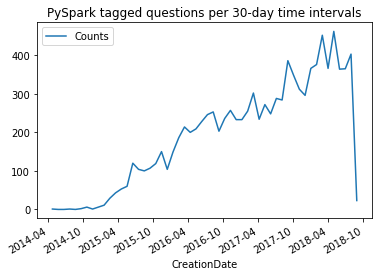

In [16]:
# Only keep the date time
questions_pyspark_df["CreationDate"] = pd.to_datetime(questions_pyspark_df["CreationDate"])
# Count by 30 days interval
questions_pyspark_per_30days = questions_pyspark_df.groupby(pd.Grouper(key="CreationDate", freq='30D', label="left")).size().reset_index(name="Counts")
questions_pyspark_per_30days.plot(x="CreationDate", y="Counts", title="PySpark tagged questions per 30-day time intervals")


We noticed that the number of questions tends to augment with time. The last drop at the end is caused by the fact that we don't have much data for the months of September, since the data collection ends at the beginning of september. There is certainly a positive correlation between time and the number of questions